# Gold Price Prediction


In [45]:
# Import libraries for data manipulation and analysis
import pandas as pd
import seaborn as sns
import mplfinance as mpf
import os

# Import libraries for data visualization
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.dates import DateFormatter

# Import tools for model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Import utilities for Jupyter display and model persistence
from IPython.display import display, HTML
import pickle

In [37]:
class Data:
    """Manages loading and manipulation of CSV data for analysis.

    This class encapsulates functionality to load a CSV file, validate its accessibility,
    and provide methods to inspect the data, including retrieving the first rows (Head),
    last rows (Tail), or random samples (sample). The basic_data_load method offers a
    unified interface for these operations based on a mode parameter. The class is
    optimized for memory efficiency by avoiding unnecessary DataFrame copies and includes
    comprehensive error handling to ensure reliability.
    """

    def __init__(self, file_path, copy_data=False):
        """
        Initialize the Data class with a file path and optional DataFrame copying.

        This method sets up the file path, loads the CSV data using dataLoader, and stores
        it in self.data. It optionally creates a copy of the DataFrame to preserve the
        original data if modifications are expected, optimizing memory usage by default.

        Parameters:
        - file_path (str): Path to the CSV file containing the dataset. Expected to be a
                           valid file path accessible on the system (e.g., 'data.csv').
        - copy_data (bool): If True, creates a copy of the loaded DataFrame to preserve
                            the original data. Defaults to False to minimize memory usage.

        Raises:
        - FileNotFoundError: If the specified file_path does not exist.
        - ValueError: If the CSV file cannot be read (e.g., invalid format).
        """
        # Convert the file path to a Path object for robust cross-platform handling
        self.file_path = Path(file_path)
        # Load the CSV data into self.data using dataLoader
        self.data = self.dataLoader()
        # Store the original data, either as a reference or a copy based on copy_data
        self.original_data = self.data if not copy_data else self.data.copy()

    def dataLoader(self):
        """
        Load and validate the CSV data from the specified file path.

        This method checks if the file exists and reads it into a pandas DataFrame,
        ensuring the data is valid for further processing. It aligns with the provided
        format's dataLoader method, adding error handling for robustness.

        Returns:
        - pandas.DataFrame: The loaded DataFrame containing the CSV data.

        Raises:
        - FileNotFoundError: If the file at file_path does not exist.
        - ValueError: If the CSV file cannot be read (e.g., invalid format).
        """
        # Check if the file exists at the specified path
        if not self.file_path.exists():
            raise FileNotFoundError(f"File not found: {self.file_path}")

        # Attempt to read the CSV file into a DataFrame
        try:
            return pd.read_csv(self.file_path)
        except Exception as e:
            # Raise an error if CSV reading fails (e.g., invalid format)
            raise ValueError(f"Failed to read CSV file {self.file_path}: {str(e)}")

    def Head(self, numbers=5):
        """
        Return the first n rows of the DataFrame.

        This method retrieves the first 'numbers' rows of the DataFrame, allowing users
        to inspect the beginning of the dataset. It follows the provided format's Head
        method, with a default of 5 rows for a standard preview.

        Parameters:
        - numbers (int): Number of rows to return. Defaults to 5 for consistency with
                         pandas' default head() behavior.

        Returns:
        - pandas.DataFrame: The first 'numbers' rows of the DataFrame.

        Raises:
        - ValueError: If numbers is non-positive.
        """
        # Validate that the number of rows is positive
        if numbers <= 0:
            raise ValueError("Number of rows must be positive")
        # Return the first 'numbers' rows of the DataFrame
        return self.data.head(numbers)

    def Tail(self, numbers=5):
        """
        Return the last n rows of the DataFrame.

        This method retrieves the last 'numbers' rows of the DataFrame, allowing users
        to inspect the end of the dataset. It follows the provided format's Tail method,
        with a default of 5 rows for a standard preview.

        Parameters:
        - numbers (int): Number of rows to return. Defaults to 5 for consistency with
                         pandas' default tail() behavior.

        Returns:
        - pandas.DataFrame: The last 'numbers' rows of the DataFrame.

        Raises:
        - ValueError: If numbers is non-positive.
        """
        # Validate that the number of rows is positive
        if numbers <= 0:
            raise ValueError("Number of rows must be positive")
        # Return the last 'numbers' rows of the DataFrame
        return self.data.tail(numbers)

    def Sample(self, numbers=5):
        """
        Return a random sample of n rows from the DataFrame.

        This method retrieves a random sample of 'numbers' rows from the DataFrame,
        useful for exploring the dataset. It follows the provided format's sample method,
        with a default of 5 rows for a standard sample.

        Parameters:
        - numbers (int): Number of rows to return. Defaults to 5 for a reasonable sample size.

        Returns:
        - pandas.DataFrame: A random sample of 'numbers' rows from the DataFrame.

        Raises:
        - ValueError: If numbers is non-positive or exceeds the DataFrame size.
        """
        # Validate that the number of rows is positive
        if numbers <= 0:
            raise ValueError("Number of rows must be positive")
        # Validate that the sample size does not exceed the DataFrame size
        if numbers > len(self.data):
            raise ValueError(
                f"Sample size {numbers} exceeds DataFrame size {len(self.data)}"
            )
        # Return a random sample of 'numbers' rows
        return self.data.sample(numbers)

    def Basic_data_load(self, numbers=5, mode="head"):
        """
        Retrieve a subset of the DataFrame based on the specified mode.

        This method provides a unified interface to retrieve data using different modes
        ('head', 'tail', or 'sample'), as specified in the provided format. It normalizes
        the mode parameter and calls the appropriate method (Head, Tail, or sample).

        Parameters:
        - numbers (int): Number of rows to return. Defaults to 5 for a standard preview.
        - mode (str): The mode of data retrieval ('head', 'tail', or 'sample'). Defaults
                      to 'head'. Case-insensitive.

        Returns:
        - pandas.DataFrame: The requested subset of the DataFrame based on the mode.

        Raises:
        - ValueError: If numbers is non-positive or mode is invalid.
        """
        # Normalize the mode parameter to lowercase and remove whitespace
        mode = mode.lower().strip()
        # Validate the mode parameter
        if mode not in ["head", "tail", "sample"]:
            raise ValueError("Mode must be 'head', 'tail', or 'sample'")
        # Call the appropriate method based on the mode
        if mode == "head":
            return self.Head(numbers)
        elif mode == "tail":
            return self.Tail(numbers)
        else:  # mode == 'sample'
            return self.sample(numbers)

    def reset_to_original(self):
        """
        Reset the working DataFrame to the original loaded data.

        This method restores self.data to the original DataFrame state, useful if
        modifications were made to self.data and the user wants to revert to the initial
        dataset. It creates a copy to avoid reference issues.

        Returns:
        - None
        """
        # Restore self.data to the original data (copy to avoid modifying original_data)
        self.data = self.original_data.copy()

In [38]:
# -------------------------------------------------------------
# Phase 1 - Step 2: Data Preprocessing
# -------------------------------------------------------------
# This class is designed to clean and prepare raw financial data
# for use in machine learning or statistical modeling.
#
# It provides the following preprocessing capabilities:
#   1. Clean textual and symbolic noise from data (%, commas).
#   2.  volume strings like '1.2M' into numeric values.
#   3. Handle missing and duplicate data entries.
#   4. Split the dataset into features and target variable.
# -------------------------------------------------------------


class DataPreprocessing:
    def __init__(self, df):
        """
        Initialize the preprocessing class with a pandas DataFrame.

        Parameters:
        df (pd.DataFrame): The raw input dataset to be cleaned and transformed.
        """
        self.df = df

    def clean_data(self):
        """
        Perform basic data cleaning on the dataset.
        Operations performed:
        - Removes commas and percentage signs from all string values using regex.
        - Drops all rows that contain NaN (missing) values.
        - Removes duplicate rows to ensure data integrity.

        Returns:
        pd.DataFrame: The cleaned DataFrame ready for further preprocessing.
        """
        # Remove ',' and '%' symbols from all string cells to ease numeric conversion later
        self.df.replace({",": "", "%": ""}, regex=True, inplace=True)

        # Drop any rows that have missing values
        self.df.dropna(inplace=True)

        # Drop duplicate rows if any
        self.df.drop_duplicates(inplace=True)

        return self.df

    def convert_dtypes(self):
        """
        Convert specific columns to appropriate numeric types for modeling.

        Specific transformations:
        - 'Vol.': Converts volume strings with suffixes:
            'K' (thousand) -> multiplied by 1e3,
            'M' (million)  -> multiplied by 1e6.
          Example: '1.5M' → 1,500,000
        - ['Price', 'Open', 'High', 'Low', 'Change %']:
            Converts to float using pandas `to_numeric` with error coercion.

        Returns:
        pd.DataFrame: DataFrame with updated, numeric types for required columns.
        """
        # Handle 'Vol.' column: Convert K and M to proper float values
        self.df["Vol."] = (
            self.df["Vol."]
            .replace({"K": "*1e3", "M": "*1e6"}, regex=True)
            .map(pd.eval)
            .astype(float)
        )

        # Define the columns to be numerically converted
        cols = ["Price", "Open", "High", "Low", "Change %"]

        # Convert each column to numeric, invalid parsing will be set as NaN
        for col in cols:
            self.df[col] = pd.to_numeric(self.df[col], errors="coerce")

        return self.df

    def get_features_labels(self):
        """
        Extracts features (X) and target (y) for training a regression model.

        Selected features (independent variables):
        - 'Open'   : Opening price of the stock.
        - 'High'   : Highest price of the day.
        - 'Low'    : Lowest price of the day.
        - 'Vol.'   : Volume of trades (in numeric format).

        Target variable (dependent variable):
        - 'Price'  : Closing price of the stock (label to be predicted).

        Returns:
        tuple:
            X (pd.DataFrame): Feature matrix used for modeling.
            y (pd.Series): Target variable to be predicted.
        """
        # Extract the features and target columns
        X = self.df[["Open", "High", "Low", "Vol."]]
        y = self.df["Price"]
        return X, y

In [39]:
# Class definition for Graphs, which handles visualization of financial data
class Graphs:
    """Financial data visualizer with univariate and bivariate analysis"""

    # Constructor method to initialize the class
    # Parameters:
    #   - data (pd.DataFrame): Input Pandas DataFrame containing financial data with expected columns
    #                         ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
    # Functionality:
    #   - Stores a copy of the input DataFrame to avoid modifying the original
    #   - Calls _preprocess_data to clean and format the data
    #   - Initializes an empty list to store generated matplotlib figures
    # KeyError Note: Expects 'Price', not 'Close'. DataFrame should be preprocessed to rename 'Close' to 'Price'.
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()  # Create a copy to preserve original data
        self._preprocess_data()  # Clean and format the data
        self.figures = []  # List to store matplotlib figure objects for plots

    # Internal method to preprocess the DataFrame
    # Functionality:
    #   - Cleans numeric columns ('Price', 'Open', 'High', 'Low') by removing commas and converting to float
    #   - Converts 'Vol.' column from string (e.g., '1.2M') to numeric using convert_volume
    #   - Cleans 'Change %' by removing '%' and converting to float
    #   - Converts 'Date' to datetime format
    #   - Sorts data by 'Date' in ascending order
    # Parameters: None (operates on self.data)
    # KeyError Note: Expects 'Price'. If 'Close' exists instead, rename it before initializing the class.
    def _preprocess_data(self):
        # Clean numeric columns
        for col in ["Price", "Open", "High", "Low"]:
            self.data[col] = (
                self.data[col].astype(str).str.replace(",", "").astype(float)
            )

        # Convert volume column
        self.data["Vol."] = self.data["Vol."].apply(Graphs.convert_volume)

        # Clean change % column
        if self.data["Change %"].dtype == object:
            self.data["Change %"] = (
                self.data["Change %"].str.replace("%", "").astype(float)
            )

        # Convert Date to datetime
        self.data["Date"] = pd.to_datetime(self.data["Date"])

        # Sort by Date
        self.data.sort_values("Date", inplace=True)

    # Static method to convert volume strings (e.g., '1.2M') to numeric values
    # Parameters:
    #   - vol_str: Input string or numeric value representing trading volume
    # Returns:
    #   - float: Converted volume (e.g., '1.2M' -> 1200000.0, '-' -> 0.0)
    # Functionality:
    #   - Handles strings ending in 'K', 'M', 'B' (thousands, millions, billions)
    #   - Converts comma-separated strings to float
    #   - Returns 0.0 for invalid or '-' inputs
    #   - Returns numeric inputs unchanged
    @staticmethod
    def convert_volume(vol_str):
        if isinstance(vol_str, str):
            vol_str = vol_str.strip()
            if vol_str[-1] == "K":
                return float(vol_str[:-1]) * 1_000
            elif vol_str[-1] == "M":
                return float(vol_str[:-1]) * 1_000_000
            elif vol_str[-1] == "B":
                return float(vol_str[:-1]) * 1_000_000_000
            elif vol_str == "-":
                return 0.0
            else:
                try:
                    return float(vol_str.replace(",", ""))
                except ValueError:
                    return 0.0
        return vol_str

    # Internal method to set up plot configurations
    # Parameters:
    #   - title (str): Plot title (default: '')
    #   - xlabel (str): X-axis label (default: 'Date')
    #   - ylabel (str): Y-axis label (default: '')
    #   - grid (bool): Whether to display grid lines (default: True)
    # Returns:
    #   - tuple: (matplotlib.figure.Figure, matplotlib.axes.Axes) for the plot
    # Functionality:
    #   - Creates a new figure and axis with specified size (12x6 inches)
    #   - Sets title, x-label, y-label, and optional grid
    def _setup_plot(self, title="", xlabel="Date", ylabel="", grid=True):
        """Configure plot settings"""
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_title(title, pad=20, fontsize=14, fontweight="bold")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if grid:
            ax.grid(True, linestyle="--", alpha=0.7)
        return fig, ax

    # --------------------------
    # UNIVARIATE ANALYSIS PLOTS
    # (Analyzing single variables)
    # --------------------------

    # Method to plot histogram of closing prices
    # Parameters: None (uses self.data['Price'])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Creates a histogram of 'Price' column with 30 bins
    #   - Uses blue color with white edges
    #   - Stores figure in self.figures
    # KeyError Note: Uses 'Price', not 'Close'. Error occurs if 'Close' is referenced instead.
    def plot_price_distribution(self):
        """Histogram of closing prices (Univariate)"""
        fig, ax = self._setup_plot("Price Distribution", xlabel="Price", ylabel="Frequency")
        ax.hist(self.data["Price"], bins=30, color="#1f77b4", edgecolor="white")
        self.figures.append(fig)
        return fig

    # Method to plot histogram of trading volume
    # Parameters: None (uses self.data['Vol.'])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Creates a histogram of 'Vol.' column with 30 bins
    #   - Uses cyan color with white edges
    #   - Stores figure in self.figures
    def plot_volume_distribution(self):
        """Histogram of trading volume (Univariate)"""
        fig, ax = self._setup_plot("Volume Distribution", xlabel="Volume" ,ylabel="Frequency")
        ax.hist(self.data["Vol."], bins=30, color="#17becf", edgecolor="white")
        self.figures.append(fig)
        return fig

    # Method to plot histogram of daily percentage changes
    # Parameters: None (uses self.data['Change %'])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Creates a histogram of 'Change %' column with 30 bins
    #   - Adds a red vertical line at 0% change
    #   - Uses orange color with white edges
    #   - Stores figure in self.figures
    def plot_change_distribution(self):
        """Distribution of daily changes (Univariate)"""
        fig, ax = self._setup_plot("Daily Change Distribution",xlabel="Change %", ylabel="Frequency")
        ax.hist(self.data["Change %"], bins=30, color="#ff7f0e", edgecolor="white")
        ax.axvline(0, color="red", linestyle="--")
        self.figures.append(fig)
        return fig

    # Method: Box plot of OHLC prices
    # Parameters: None (uses self.data[['Open', 'High', 'Low', 'Price']])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Creates a box plot for 'Open', 'High', 'Low', 'Price' to show distribution and outliers
    #   - Stores figure in self.figures
    # Deprecation Fix: Uses 'tick_labels' instead of 'labels' to avoid MatplotlibDeprecationWarning
    def plot_ohlc_box(self):
        """Box plot of OHLC prices (Univariate)"""
        fig, ax = self._setup_plot(
            "OHLC Price Distribution", xlabel="Price Type", ylabel="Price ($)"
        )
        ax.boxplot(
            [
                self.data["Open"],
                self.data["High"],
                self.data["Low"],
                self.data["Price"],
            ],
            tick_labels=["Open", "High", "Low", "Price"],
        )
        self.figures.append(fig)
        return fig

    # Method: Violin plot of daily percentage changes
    # Parameters: None (uses self.data['Change %'])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Creates a violin plot to show the distribution of 'Change %' with kernel density estimation
    #   - Stores figure in self.figures
    def plot_change_violin(self):
        """Violin plot of daily percentage changes (Univariate)"""
        fig, ax = self._setup_plot(
            "Daily Change Violin Plot", xlabel="Change %", ylabel="Density"
        )
        sns.violinplot(x=self.data["Change %"], ax=ax, color="#ff7f0e")
        ax.axvline(0, color="red", linestyle="--")
        self.figures.append(fig)
        return fig

    # --------------------------
    # BIVARIATE ANALYSIS PLOTS
    # (Analyzing relationships between two variables)
    # --------------------------

    # Method to plot scatter of price vs. volume
    # Parameters: None (uses self.data['Vol.'], self.data['Price'], self.data['Change %'])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Creates a scatter plot of volume vs. price
    #   - Colors points by 'Change %' using RdYlGn colormap
    #   - Adds a colorbar for change percentage
    #   - Stores figure in self.figures
    # KeyError Note: Uses 'Price', not 'Close'. Error occurs if 'Close' is used.
    def plot_price_volume(self):
        """Price vs Volume scatter plot (Bivariate)"""
        fig, ax = self._setup_plot("Price vs Volume", ylabel="Price ($)")
        sc = ax.scatter(
            self.data["Vol."],
            self.data["Price"],
            c=self.data["Change %"],
            cmap="RdYlGn",
            alpha=0.7,
        )
        plt.colorbar(sc, label="Daily Change %")
        ax.set_xlabel("Volume")
        self.figures.append(fig)
        return fig

    # Method to plot OHLC (Open, High, Low, Close) relationships
    # Parameters: None (uses self.data['Date'], self.data['Low'], self.data['High'], self.data['Open'])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Plots vertical lines for each day's high-low range
    #   - Marks open and close prices with horizontal markers
    #   - Colors markers green if Low >= Open, red otherwise
    #   - Formats x-axis dates as YYYY-MM
    #   - Stores figure in self.figures
    # KeyError Note: Uses 'Open', 'Low', 'High', not 'Close'. Error not directly related to this method.
    def plot_ohlc(self):
        """OHLC relationship plot (Bivariate - Time vs Price components)"""
        fig, ax = self._setup_plot("OHLC Prices", ylabel="Price ($)")

        # Plot each day's range
        for idx, row in self.data.iterrows():
            ax.plot(
                [row["Date"], row["Date"]],
                [row["Low"], row["High"]],
                color="black",
                linewidth=1,
            )

            # Color open/close based on change
            color = "green" if row["Low"] >= row["Open"] else "red"
            ax.plot(row["Date"], row["Open"], marker="_", markersize=10, color=color)
            ax.plot(row["Date"], row["Low"], marker="_", markersize=10, color=color)

        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        fig.autofmt_xdate()
        self.figures.append(fig)
        return fig

    # Method to plot correlation heatmap of numeric features
    # Parameters: None (uses self.data[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Computes correlation matrix for numeric columns
    #   - Creates a heatmap with coolwarm colormap
    #   - Adds correlation values as text on the heatmap
    #   - Stores figure in self.figures
    # KeyError Note: Uses 'Price', not 'Close'. Error occurs if 'Close' is referenced.
    def plot_correlation_heatmap(self):
        """Correlation between all numeric features (Multivariate)"""
        numeric_data = self.data[["Price", "Open", "High", "Low", "Vol.", "Change %"]]
        corr = numeric_data.corr()

        fig, ax = plt.subplots(figsize=(10, 8))
        cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
        fig.colorbar(cax)

        ax.set_title("Feature Correlations", pad=20)
        ax.set_xticks(range(len(corr.columns)))
        ax.set_yticks(range(len(corr.columns)))
        ax.set_xticklabels(corr.columns, rotation=45, ha="left")
        ax.set_yticklabels(corr.columns)

        for i in range(len(corr.columns)):
            for j in range(len(corr.columns)):
                ax.text(
                    j,
                    i,
                    f"{corr.iloc[i,j]:.2f}",
                    ha="center",
                    va="center",
                    color="white",
                )

        self.figures.append(fig)
        return fig

    # Method to plot time series of a specified column
    # Parameters:
    #   - column (str): Name of the column to plot (e.g., 'Price', 'Vol.', 'Change %')
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Plots the specified column against 'Date'
    #   - Formats x-axis as YYYY-MM
    #   - Stores figure in self.figures
    # KeyError Note: If 'Close' is passed as column, it causes KeyError because the DataFrame has 'Price'.
    def plot_time_series(self, column: str):
        """Time series plot of any column (Bivariate - Time vs Variable)"""
        fig, ax = self._setup_plot(f"{column} Over Time", ylabel=column)
        ax.plot(self.data["Date"], self.data[column], linewidth=1.5)
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        fig.autofmt_xdate()
        self.figures.append(fig)
        return fig

    # Method: Candlestick chart for OHLC data
    # Parameters: None (uses self.data[['Date', 'Open', 'High', 'Low', 'Price', 'Vol.']])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Creates a candlestick chart using mplfinance.plot with type='candle'
    #   - Sets Date as index for mplfinance compatibility
    #   - Captures the figure created by mplfinance
    #   - Stores figure in self.figures
    # Warning Fix: Sets warn_too_much_data to suppress mplfinance data volume warning
    def plot_candlestick(self):
        """Candlestick chart for OHLC data (Bivariate)"""
        # Prepare data for candlestick
        ohlc_data = self.data[["Date", "Open", "High", "Low", "Price", "Vol."]].copy()
        ohlc_data = ohlc_data.rename(columns={"Price": "Close", "Vol.": "Volume"})
        ohlc_data.set_index("Date", inplace=True)

        # Create candlestick plot and capture figure
        mpf.plot(
            ohlc_data,
            type="candle",
            style="classic",
            title="Candlestick Chart",
            ylabel="Price ($)",
            figsize=(12, 6),
            warn_too_much_data=len(ohlc_data) + 100,
        )
        fig = plt.gcf()  # Get the current figure created by mplfinance
        self.figures.append(fig)
        return fig

    # Method: Moving average plot
    # Parameters: None (uses self.data['Date'], self.data['Price'])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Plots 'Price' with 20-day and 50-day moving averages
    #   - Formats x-axis as YYYY-MM
    #   - Stores figure in self.figures
    def plot_moving_average(self):
        """Moving average plot for Price (Bivariate)"""
        fig, ax = self._setup_plot("Price with Moving Averages", ylabel="Price ($)")
        ax.plot(self.data["Date"], self.data["Price"], label="Price", linewidth=1.5)
        ax.plot(
            self.data["Date"],
            self.data["Price"].rolling(window=20).mean(),
            label="20-Day MA",
            color="orange",
            linewidth=1.5,
        )
        ax.plot(
            self.data["Date"],
            self.data["Price"].rolling(window=50).mean(),
            label="50-Day MA",
            color="purple",
            linewidth=1.5,
        )
        ax.legend()
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        fig.autofmt_xdate()
        self.figures.append(fig)
        return fig

    # Method: Area plot for cumulative volume
    # Parameters: None (uses self.data['Date'], self.data['Vol.'])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Plots cumulative volume as a filled area
    #   - Formats x-axis as YYYY-MM
    #   - Stores figure in self.figures
    def plot_volume_area(self):
        """Area plot for cumulative volume (Bivariate)"""
        fig, ax = self._setup_plot(
            "Cumulative Volume Over Time", ylabel="Cumulative Volume"
        )
        ax.fill_between(
            self.data["Date"], self.data["Vol."].cumsum(), color="#17becf", alpha=0.5
        )
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        fig.autofmt_xdate()
        self.figures.append(fig)
        return fig

    # Method: Pair plot for numeric columns
    # Parameters: None (uses self.data[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']])
    # Returns: matplotlib.figure.Figure
    # Functionality:
    #   - Creates a scatter matrix for all numeric columns using seaborn
    #   - Stores figure in self.figures
    def plot_pair_plot(self):
        """Pair plot for numeric features (Multivariate)"""
        numeric_data = self.data[["Price", "Open", "High", "Low", "Vol.", "Change %"]]
        pair_plot = sns.pairplot(numeric_data)
        pair_plot.fig.suptitle(
            "Pair Plot of Numeric Features", y=1.02, fontsize=14, fontweight="bold"
        )
        self.figures.append(pair_plot.fig)
        return pair_plot.fig

    # --------------------------
    # COMPREHENSIVE PLOTTING
    # --------------------------

    # Method to generate all univariate plots
    # Parameters: None
    # Returns: list of last 5 matplotlib.figure.Figure objects
    # Functionality:
    #   - Calls plot_price_distribution, plot_volume_distribution, plot_change_distribution,
    #     plot_ohlc_box, and plot_change_violin
    #   - Returns the last five figures stored in self.figures
    def plot_all_univariate(self):
        """Generate all univariate analysis plots"""
        print("Generating Univariate Analysis Plots...")
        self.plot_price_distribution()
        self.plot_volume_distribution()
        self.plot_change_distribution()
        self.plot_ohlc_box()
        self.plot_change_violin()
        return self.figures[-5:]  # Return last 5 figures

    # Method to generate all bivariate plots
    # Parameters: None
    # Returns: list of last 9 matplotlib.figure.Figure objects
    # Functionality:
    #   - Calls plot_price_volume, plot_ohlc, plot_correlation_heatmap, plot_candlestick,
    #     plot_moving_average, plot_volume_area, and plot_time_series for 'Price', 'Vol.', 'Change %'
    #   - Returns the last nine figures stored in self.figures
    # KeyError Note: Calls plot_time_series('Price'), which works, but error occurs if 'Close' is passed.
    def plot_all_bivariate(self):
        """Generate all bivariate analysis plots"""
        print("Generating Bivariate Analysis Plots...")
        self.plot_price_volume()
        self.plot_ohlc()
        self.plot_correlation_heatmap()
        self.plot_candlestick()
        self.plot_moving_average()
        self.plot_volume_area()
        for col in ["Price", "Vol.", "Change %"]:
            self.plot_time_series(col)
        return self.figures[-9:]  # Return last 9 figures

    # Method to generate all available plots
    # Parameters: None
    # Returns: list of all matplotlib.figure.Figure objects
    # Functionality:
    #   - Calls plot_all_univariate, plot_all_bivariate, and plot_pair_plot
    #   - Returns all figures stored in self.figures
    # KeyError Note: Error occurs if plot_time_series is called with 'Close' elsewhere.
    def plot_all(self):
        """Generate all available plots"""
        self.plot_all_univariate()
        self.plot_all_bivariate()
        self.plot_pair_plot()
        return self.figures

    # Method to save all generated figures to files
    # Parameters:
    #   - prefix (str): Prefix for saved file names (default: 'financial_analysis')
    # Returns: None
    # Functionality:
    #   - Saves each figure in self.figures as a PNG file with the format {prefix}_{i}.png
    #   - Closes figures to free memory
    #   - Clears self.figures list
    def save_all(self, prefix="financial_analysis"):
        """Save all generated figures"""
        for i, fig in enumerate(self.figures):
            fig.savefig(f"images/{prefix}_{i}.png", bbox_inches="tight", dpi=300)
            plt.close(fig)
        print(f"Saved {len(self.figures)} plots to {prefix}_*.png")
        self.figures = []

In [40]:
# Class to split data into training and testing sets
class DataSplitter:
    def __init__(self, X, y, test_size=0.2, random_state=42):
        """
        Initialize the DataSplitter.

        Parameters:
        X (pandas.DataFrame): Feature matrix.
        y (pandas.Series): Target variable.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_state (int): Random seed for reproducibility (default is 42).
        """
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state

    def split(self):
        """
        Split the dataset into training and testing sets.

        Returns:
        tuple: X_train, X_test, y_train, y_test — split datasets.
        """
        return train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state
        )


# Class that wraps SVR model functionality (train, predict, evaluate, save)
class SVRModel:
    def __init__(self, kernel="linear"):
        """
        Initialize the SVR model.

        Parameters:
        kernel (str): Kernel type to be used in the SVR algorithm (default is 'linear').
                      Other options include 'rbf', 'poly', 'sigmoid'.
        """
        self.model = SVR(kernel=kernel)
        self.is_trained = False

    def train(self, X_train, y_train):
        """
        Train the SVR model on the training data.

        Parameters:
        X_train (pandas.DataFrame): Training features.
        y_train (pandas.Series): Training labels.
        """
        self.model.fit(X_train, y_train)
        self.is_trained = True
        print("Model trained successfully.")

    def predict(self, X_test):
        """
        Predict target values using the trained model.

        Parameters:
        X_test (pandas.DataFrame): Testing features.

        Returns:
        numpy.ndarray: Predicted values.

        Raises:
        Exception: If the model is not trained.
        """
        if not self.is_trained:
            raise Exception("Model not trained yet!")
        return self.model.predict(X_test)

    def evaluate(self, y_test, y_pred):
        """
        Evaluate the model's performance using Mean Squared Error (MSE).

        Parameters:
        y_test (pandas.Series): Actual target values.
        y_pred (numpy.ndarray): Predicted target values.

        Returns:
        float: Mean Squared Error between actual and predicted values.
        """
        return mean_squared_error(y_test, y_pred)

    def save_model(self, filename):
        """
        Save the trained model to a file in the 'Model' folder using pickle.

        Parameters:
        filename (str): Name of the file to save the model as (e.g., 'model.pkl').

        Raises:
        Exception: If the model has not been trained.
        """
        if not self.is_trained:
            raise Exception("Cannot save an untrained model!")
        
        os.makedirs("Model", exist_ok=True)  # Ensure the 'Model' folder exists
        filepath = os.path.join("Model", filename)

        with open(filepath, "wb") as file:
            pickle.dump(self.model, file)
        
        print(f"Model saved to {filepath}.")

In [41]:
# DATA CLASS
# Initialize the Data object
data_obj = Data("data/Gold_Price.csv")


# Helper function to display method results with headings
def show_result(title, df):
    print(f"--- {title} ---")
    display(df)
    print("\n")


# 1. Show loaded data (first 5 rows)
show_result("Loaded Data (first 5 rows)", data_obj.data.head())

# 2. Head (default 5 rows)
show_result("Head (default 5 rows)", data_obj.Head())

# Head with custom number of rows (3)
show_result("Head (3 rows)", data_obj.Head(3))

# 3. Tail (default 5 rows)
show_result("Tail (default 5 rows)", data_obj.Tail())

# Tail with custom number of rows (2)
show_result("Tail (2 rows)", data_obj.Tail(2))

# 4. Sample (default 5 rows)
show_result("Sample (default 5 rows)", data_obj.Sample())

# Sample with custom number of rows (4)
show_result("Sample (4 rows)", data_obj.Sample(4))

# 5. basic_data_load with default mode 'head' and 5 rows
show_result("basic_data_load (mode='head', 5 rows)", data_obj.Basic_data_load())

# basic_data_load with mode 'tail' and 3 rows
show_result(
    "basic_data_load (mode='tail', 3 rows)", data_obj.Basic_data_load(3, mode="tail")
)


# 6. Demonstrate reset_to_original
print(f"Data shape before modification: {data_obj.data.shape}")
# Modify data (drop last 10 rows)
data_obj.data = data_obj.data.iloc[:-10]
print(f"Data shape after modification: {data_obj.data.shape}")

# Reset to original
data_obj.reset_to_original()
print(f"Data shape after reset_to_original: {data_obj.data.shape}")

--- Loaded Data (first 5 rows) ---


,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%




--- Head (default 5 rows) ---


,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%




--- Head (3 rows) ---


,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%




--- Tail (default 5 rows) ---


,Date,Price,Open,High,Low,Vol.,Change %
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%
2582,01/02/2013,"1,689.90","1,675.80","1,695.00","1,672.10",0.06K,0.78%




--- Tail (2 rows) ---


,Date,Price,Open,High,Low,Vol.,Change %
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%
2582,01/02/2013,"1,689.90","1,675.80","1,695.00","1,672.10",0.06K,0.78%




--- Sample (default 5 rows) ---


,Date,Price,Open,High,Low,Vol.,Change %
2112,10/28/2014,"1,229.40","1,225.80","1,235.50","1,222.20",124.20K,0.01%
834,10/10/2019,"1,500.90","1,510.80","1,522.30","1,495.70",417.88K,-0.79%
1251,02/28/2018,"1,320.60","1,323.80","1,323.80","1,323.80",0.01K,-0.06%
736,02/27/2020,"1,645.30","1,645.30","1,645.30","1,645.30",573.29K,0.13%
730,03/06/2020,"1,674.30","1,674.20","1,692.30","1,648.50",0.41K,0.26%




--- Sample (4 rows) ---


,Date,Price,Open,High,Low,Vol.,Change %
2164,08/15/2014,"1,305.40","1,312.80","1,315.60","1,292.40",6.68K,-0.72%
2322,01/06/2014,"1,238.30","1,237.40","1,244.40","1,234.10",0.02K,-0.06%
2543,02/26/2013,"1,615.50","1,592.70","1,619.70","1,583.70",254.86K,1.82%
2294,02/13/2014,"1,300.10","1,290.80","1,303.00","1,286.20",126.05K,0.39%




--- basic_data_load (mode='head', 5 rows) ---


,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%




--- basic_data_load (mode='tail', 3 rows) ---


,Date,Price,Open,High,Low,Vol.,Change %
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%
2582,01/02/2013,"1,689.90","1,675.80","1,695.00","1,672.10",0.06K,0.78%




Data shape before modification: (2583, 7)
Data shape after modification: (2573, 7)
Data shape after reset_to_original: (2583, 7)


In [42]:
# Data Preprocessing
# Create an object of DataPreprocessing
preprocess_obj = DataPreprocessing(data_obj.data)

# Clean the data and print the cleaned DataFrame
cleaned_df = preprocess_obj.clean_data()
display(HTML("<h2>Cleaned DataFrame:</h2>"))
print(cleaned_df.head())

# Convert data types and print the DataFrame after conversion
converted_df = preprocess_obj.convert_dtypes()
display(HTML("<h2>DataFrame after converting data types:</h2>"))
print(converted_df.head())

# Get features (X) and labels (y) and print them
X, y = preprocess_obj.get_features_labels()
print("\nFeatures (X):")
print(X.head())
print("\nLabels (y):")
print(y.head())

         Date    Price     Open     High      Low     Vol. Change %
0  12/30/2022  1826.20  1821.80  1832.40  1819.80  107.50K     0.01
1  12/29/2022  1826.00  1812.30  1827.30  1811.20  105.99K     0.56
2  12/28/2022  1815.80  1822.40  1822.80  1804.20  118.08K    -0.40
3  12/27/2022  1823.10  1808.20  1841.90  1808.00  159.62K     0.74
5  12/23/2022  1804.20  1801.00  1812.20  1798.90  105.46K     0.50


         Date   Price    Open    High     Low      Vol.  Change %
0  12/30/2022  1826.2  1821.8  1832.4  1819.8  107500.0      0.01
1  12/29/2022  1826.0  1812.3  1827.3  1811.2  105990.0      0.56
2  12/28/2022  1815.8  1822.4  1822.8  1804.2  118080.0     -0.40
3  12/27/2022  1823.1  1808.2  1841.9  1808.0  159620.0      0.74
5  12/23/2022  1804.2  1801.0  1812.2  1798.9  105460.0      0.50

Features (X):
     Open    High     Low      Vol.
0  1821.8  1832.4  1819.8  107500.0
1  1812.3  1827.3  1811.2  105990.0
2  1822.4  1822.8  1804.2  118080.0
3  1808.2  1841.9  1808.0  159620.0
5  1801.0  1812.2  1798.9  105460.0

Labels (y):
0    1826.2
1    1826.0
2    1815.8
3    1823.1
5    1804.2
Name: Price, dtype: float64


Generating Univariate Analysis Plots...
Generating Bivariate Analysis Plots...


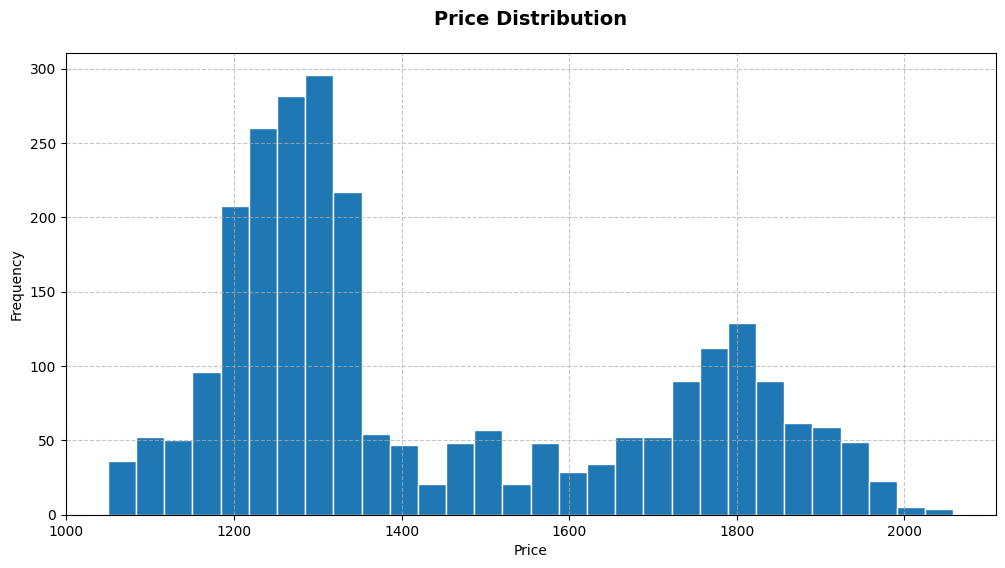

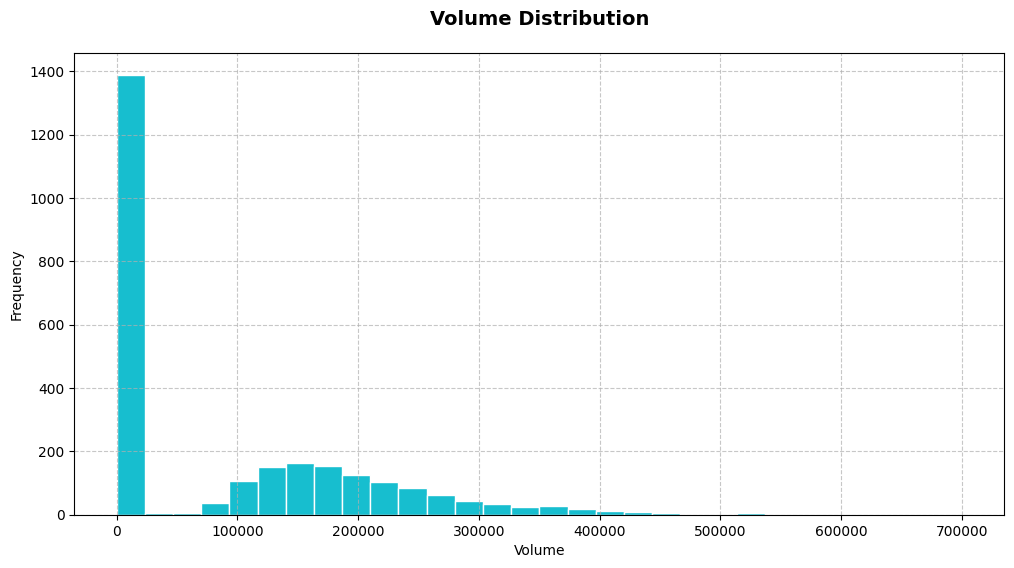

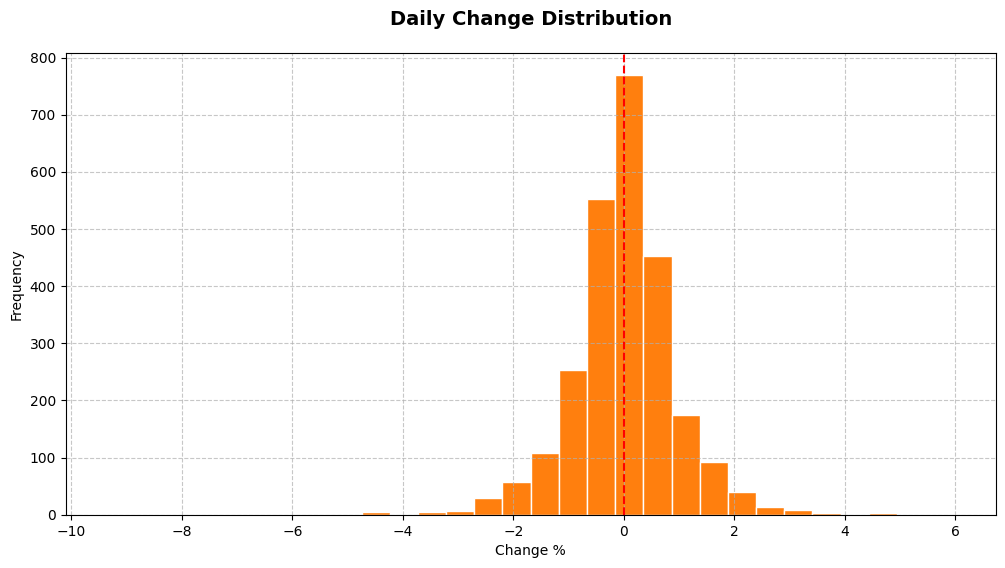

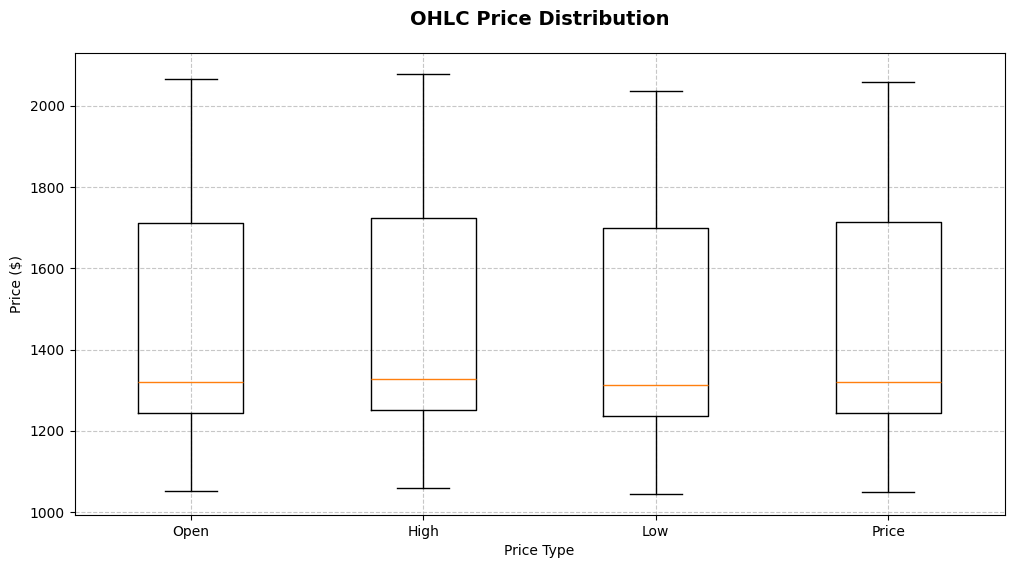

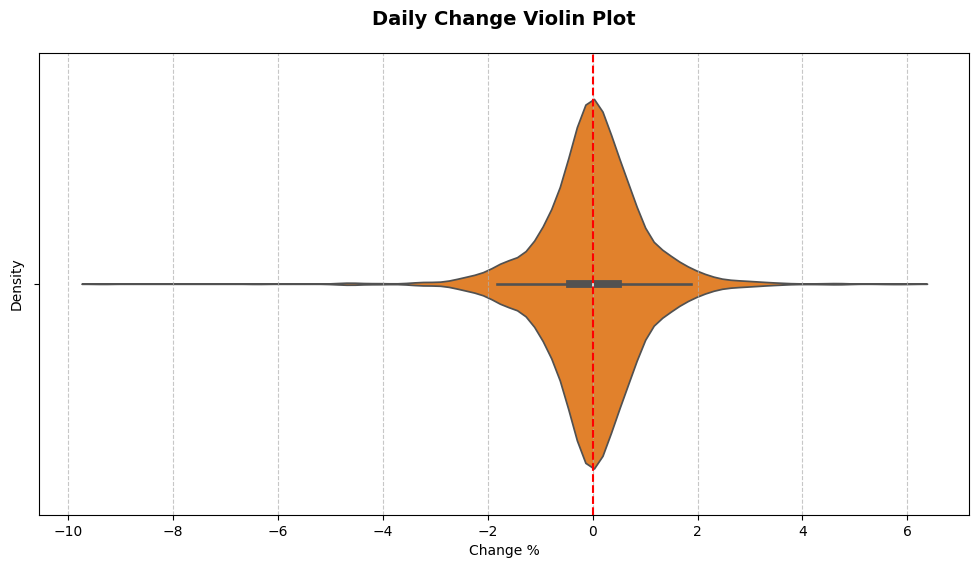

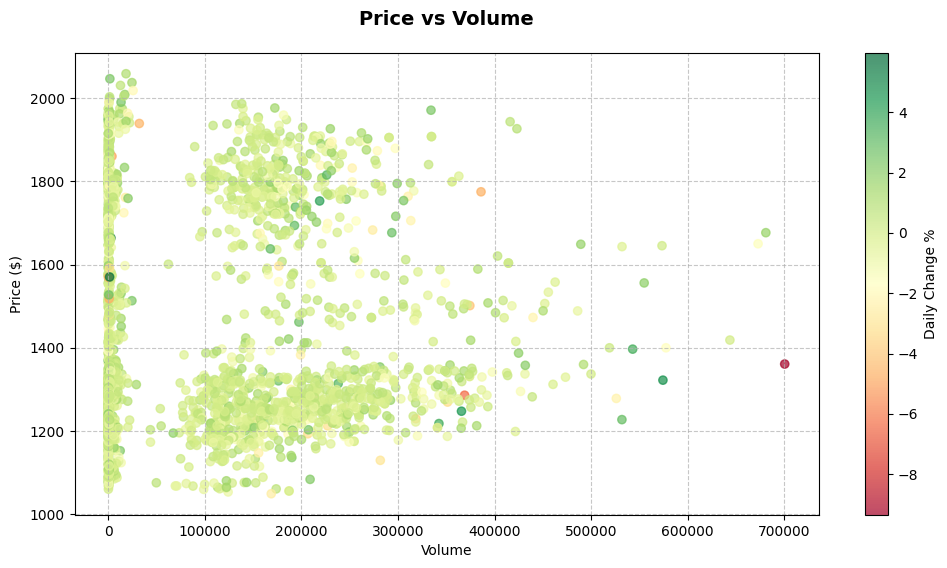

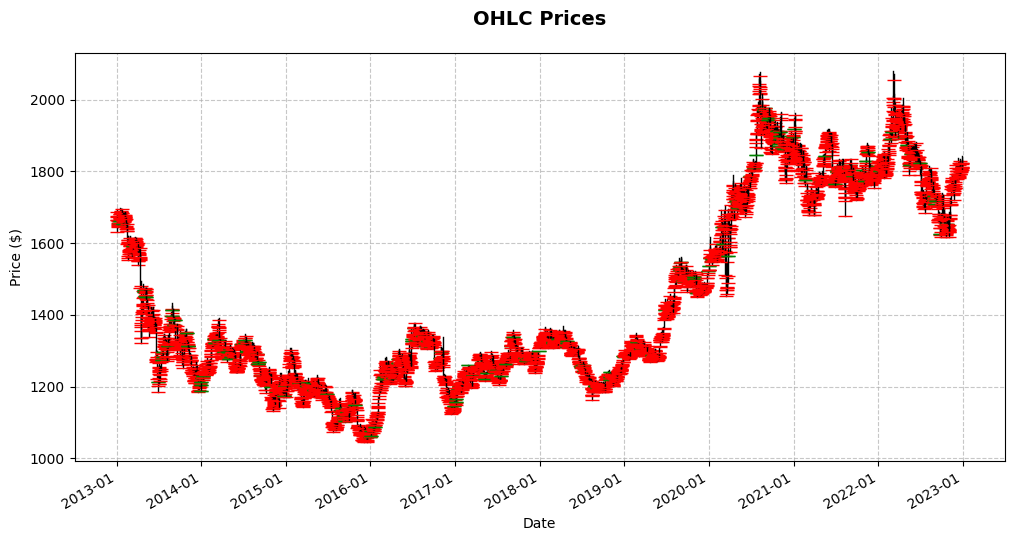

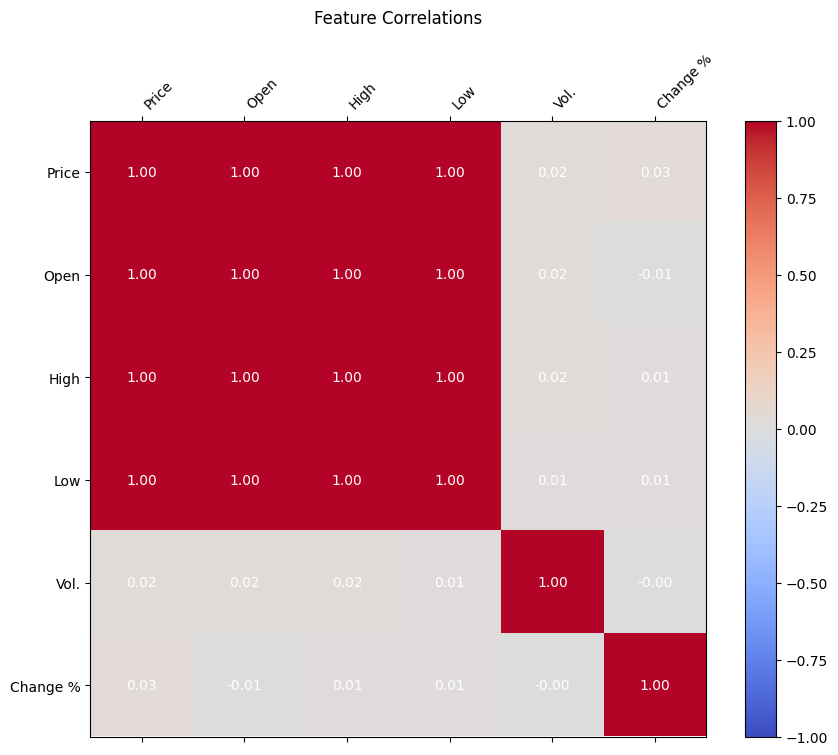

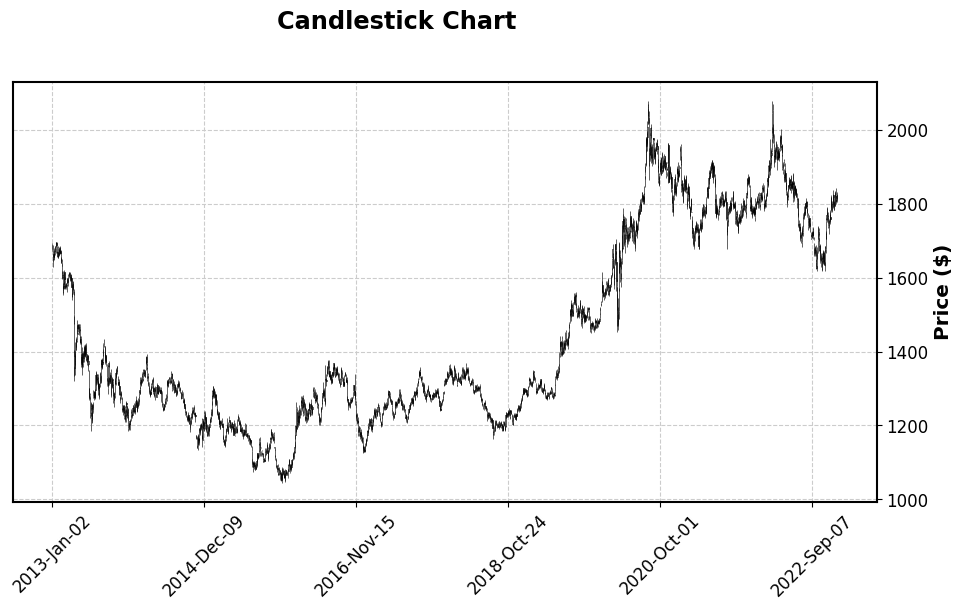

<Figure size 640x480 with 0 Axes>

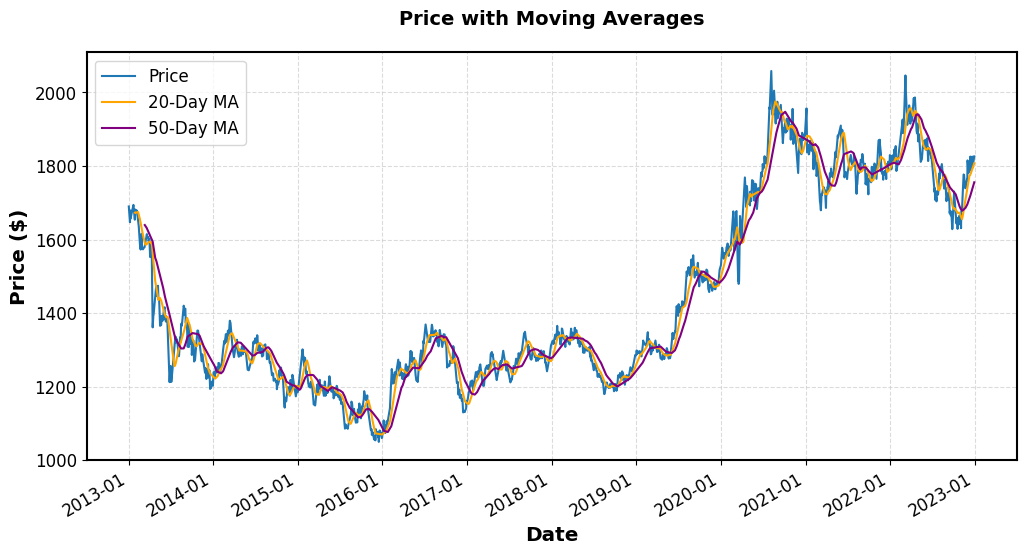

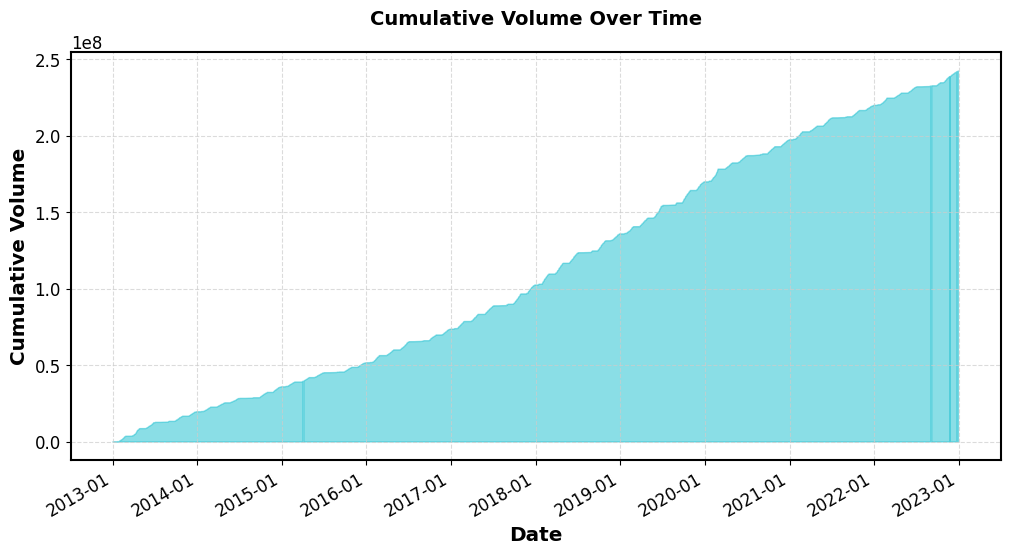

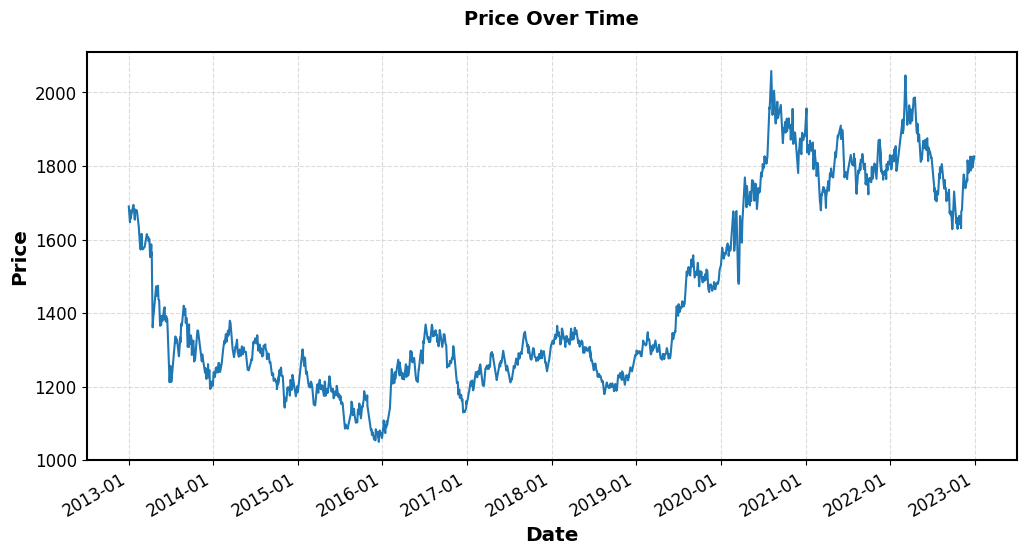

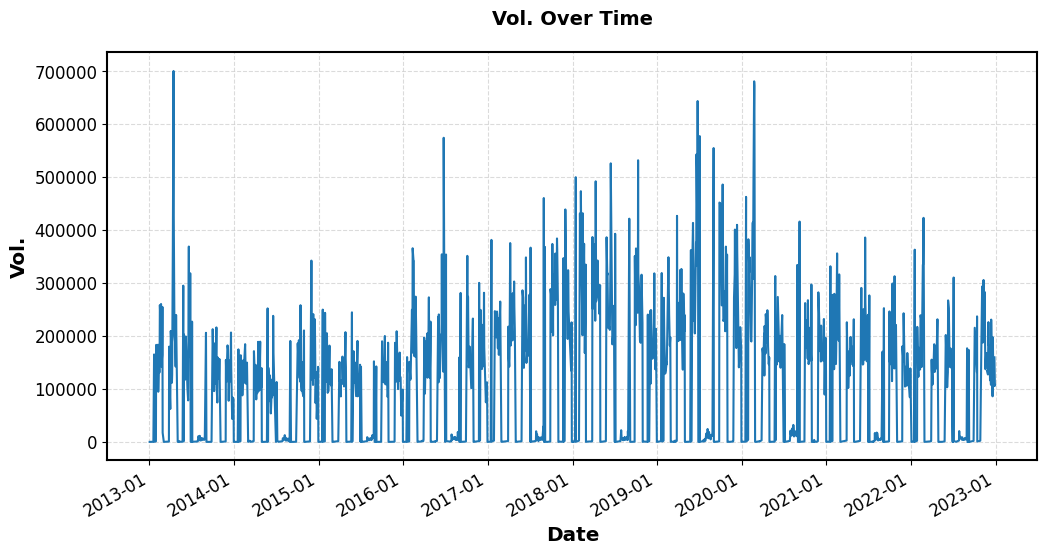

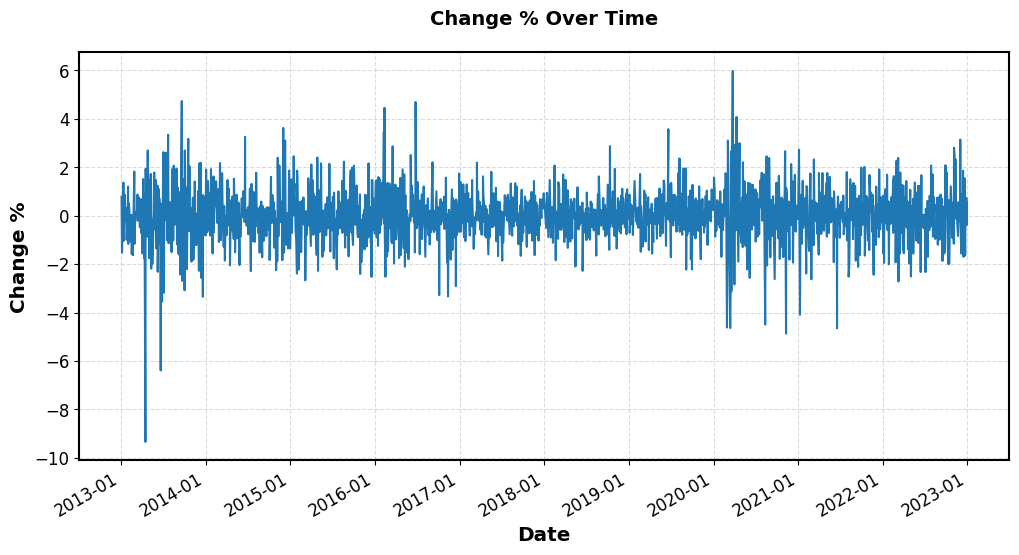

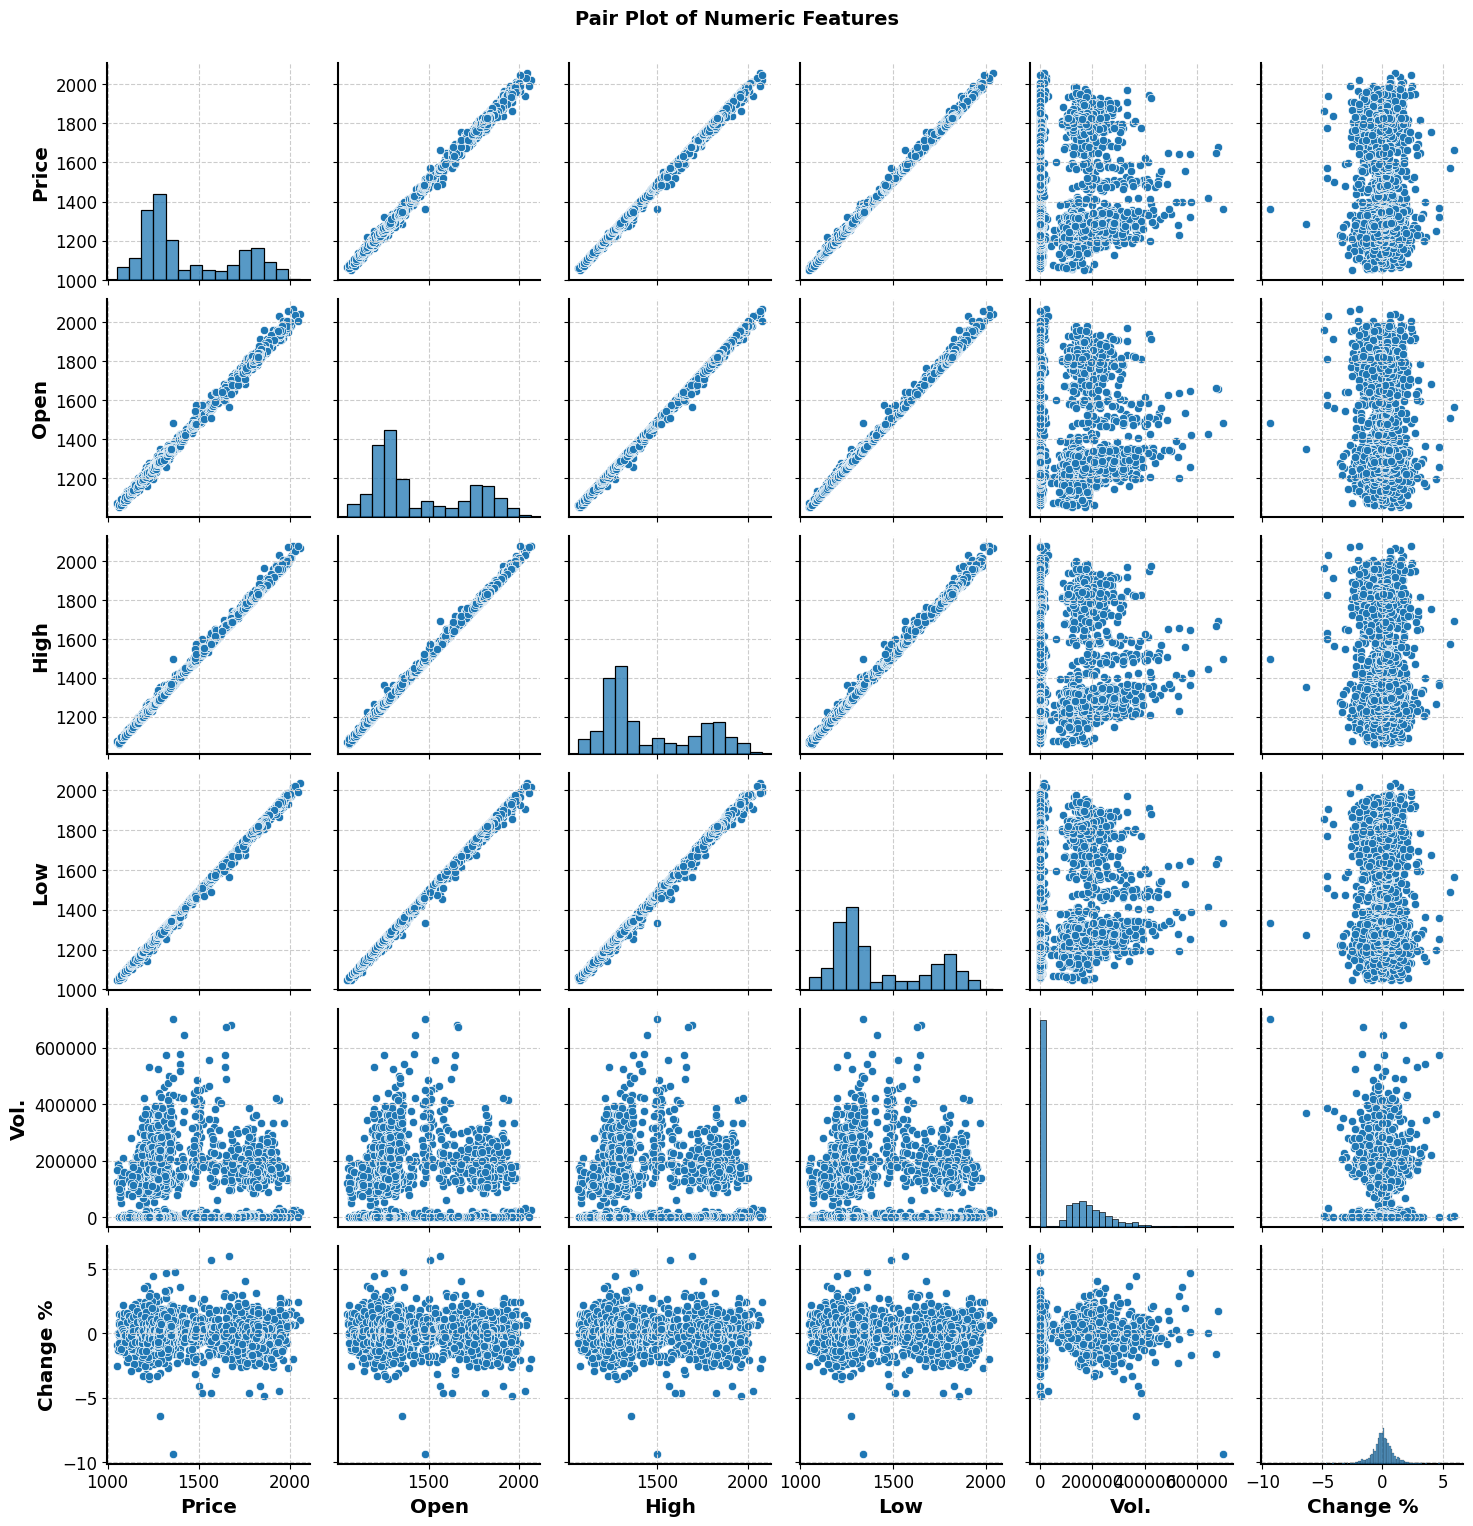

Saved 15 plots to stock_analysis_*.png


In [43]:
# Graphs Class
# Load your dataset
data = pd.read_csv("data/Gold_Price.csv")

# Initialize Graphs class with the prepared DataFrame
viz = Graphs(data)

# Generate and display all plots
all_figs = viz.plot_all()
plt.show()  # Display all plots

# Optionally save all plots to files
viz.save_all(prefix="stock_analysis")

In [46]:
# Initialize DataSplitter with features and target from cleaned DataFrame
splitter = DataSplitter(converted_df[["Open", "High", "Low"]], converted_df["Price"])
# Split data into training and testing sets
X_train, X_test, y_train, y_test = splitter.split()
# Create SVR model instance with linear kernel
svr_model = SVRModel(kernel="linear")
# Train the SVR model
svr_model.train(X_train, y_train)

# Predict on test data
y_pred = svr_model.predict(X_test)

# Evaluate predictions using Mean Squared Error
mse = svr_model.evaluate(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, create a new SVRModel instance and retrain before saving (can reuse the trained one)
svr_model = SVRModel()
svr_model.train(X_train, y_train)

# Save the trained model to disk
svr_model.save_model("svm_model.pkl")

Model trained successfully.
Mean Squared Error: 29.140630725229656
Model trained successfully.
Model saved to Model\svm_model.pkl.
